# Make a time series model

In [7]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
%matplotlib inline

## Read precipitation and evaporation time series

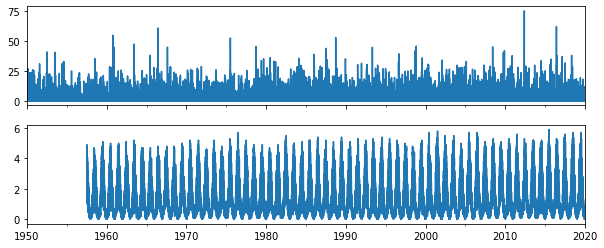

In [75]:
prec = ps.read_knmi("../meteo/precipitation_st_anthonis.txt", variables="RD").series * 1e3
prec = prec.asfreq("D").fillna(0.0)
evap = ps.read_knmi("../meteo/etmgeg_260.txt", variables="EV24").series * 1e3
evap = evap.asfreq("D").fillna(0.0)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,4), sharex=True)
prec.plot(ax=ax1)
evap.plot(ax=ax2);
plt.xlim("1950", "2020");

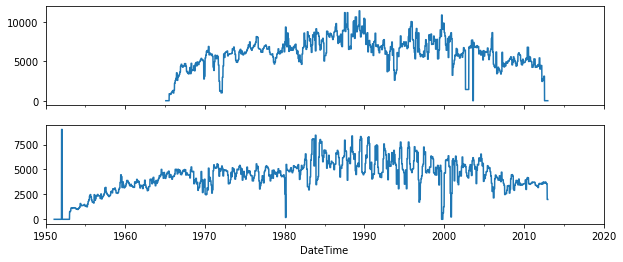

In [76]:
gwa_bm = pd.read_csv("../gw_pumping/abstraction_boxmeer_daily.csv", index_col=0, parse_dates=True, squeeze=True)
gwa_vb = pd.read_csv("../gw_pumping/abstraction_vierlingsbeek_daily.csv", index_col=0, parse_dates=True, squeeze=True)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,4), sharex=True)
gwa_vb.plot(ax=ax1)
gwa_bm.plot(ax=ax2);
plt.xlim("1950", "2020");

# Read GWL

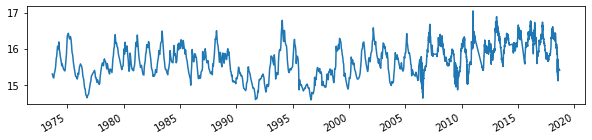

In [79]:
head = ps.read_dino("../gw_levels/raw_gwl/B46D0731001_1.csv")
head.plot(figsize=(10,2));

## Make Pastas Model

Fit report B52B0389               Fit Statistics
nfev     37                     EVP           82.55
nobs     4598                   R2             0.82
noise    True                   RMSE           0.17
tmin     1973-08-28 00:00:00    AIC           16.29
tmax     2018-09-14 00:00:00    BIC           99.93
freq     D                      Obj            8.91
warmup   3650 days 00:00:00     ___                
solver   LeastSquares           Interpolated     No

Parameters (11 were optimized)
                optimal   stderr     initial   vary
rch_A          1.092723   ±5.43%    0.798254   True
rch_a        202.648889   ±6.14%   10.000000   True
rch_srmax     81.128999   ±8.62%  250.000000   True
rch_lp         0.250000    ±nan%    0.250000  False
rch_ks         8.525061  ±11.38%  100.000000   True
rch_gamma      7.327967  ±14.13%    4.000000   True
rch_simax      2.000000    ±nan%    2.000000  False
rch_kv         0.648064   ±4.09%    1.000000   True
Boxmeer_A    -84.229482   ±4.51% -4

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=11)'}>,
 <AxesSubplot:title={'right':"Stresses: ['RD 905', 'EV24 260']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'right':"Stresses: ['0']"}>,
 <AxesSubplot:xlabel='Time [days]'>]

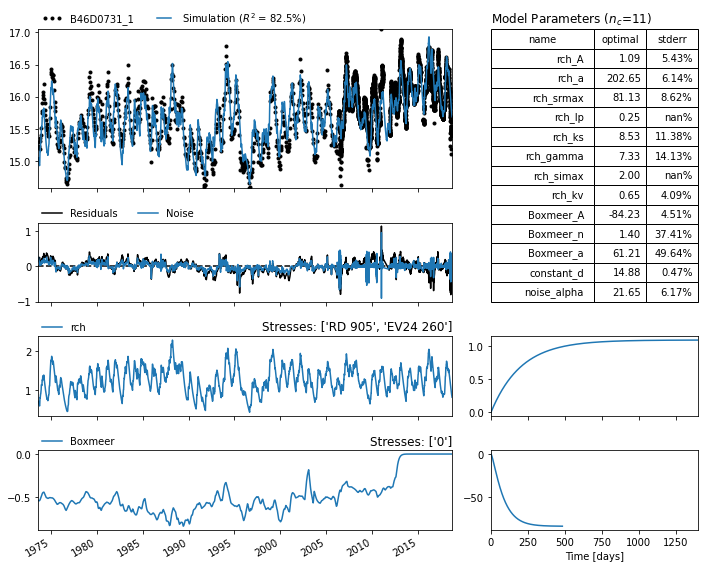

In [80]:
ml = ps.Model(head, name="B52B0389")

sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Exponential, name="rch", recharge=ps.rch.FlexModel())
sm2 = ps.StressModel(gwa_vb / 1e6, rfunc=ps.Gamma, name="Boxmeer", up=False, settings="well")
ml.add_stressmodel([sm1, sm2])
ml.set_parameter("rch_kv", vary=True)
ml.solve(tmin="1965", noise=True)
ml.plots.results()